In [1]:
#!python setup.py build_ext --inplace

In [2]:
import numpy as np
import bayesflow as bf
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from simulator import Study2_retest_4v as sim_v2

2023-10-04 17:21:20.331307: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 17:21:20.332901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 17:21:20.368002: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 17:21:20.368386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 17:21:20.953339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
import random 
random.seed(12)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
n_trials=20
v=-3
zr=0.5
a=30
ndt=0.8
alpha=1.7
dt=0.005
max_steps=10000
sv=0
szr=0
sndt=0

In [6]:
! python setup.py build_ext --inplace


In [7]:
def draw_prior():
    """Generates random draws from the prior."""
    v1 =np.random.uniform(low=0.0,high=5.0)
    v2 =np.random.uniform(low=0.0,high=5.0)

    v3 =np.random.uniform(low=-5.0,high=0.0)
    v4 =np.random.uniform(low=-5.0,high=0.0)

    zr =np.random.uniform(low=0.3,high=0.7)
    #zr =np.random.uniform(low=0.5,high=0.5)

    a  =np.random.uniform(low=0.6,high=3.0)
    ndt1 =np.random.uniform(low=0.1,high=0.7)
    ndt2 =np.random.uniform(low=0.1,high=0.7)
    ndt3 =np.random.uniform(low=0.1,high=0.7)
    ndt4 =np.random.uniform(low=0.1,high=0.7)

    sndt =np.random.uniform(low=0.0,high=0.3)
    alpha =np.random.uniform(low=1.0,high=2.0)

    return np.array([v1,v2,v3,v4,zr, a, ndt1, ndt2, ndt3, ndt4,sndt,alpha])

In [8]:
theta=draw_prior()
n_trials =( 20,25,30,35)

In [9]:
theta

array([ 2.43769007,  3.37815179, -0.1646135 , -0.60439902,  0.32261798,
        1.58014991,  0.67098033,  0.60233443,  0.25016791,  0.34294382,
        0.00360421,  1.09915742])

In [10]:
sim_v2.simulate_diffusion_2_conds(theta,n_trials)

array([[ 0.74858933,  0.        ],
       [-1.21430417,  0.        ],
       [ 1.01613285,  0.        ],
       [ 1.02309428,  0.        ],
       [ 0.84783363,  0.        ],
       [ 1.02301658,  0.        ],
       [ 1.63758675,  0.        ],
       [ 0.95607138,  0.        ],
       [ 1.15691465,  0.        ],
       [-0.74768443,  0.        ],
       [ 0.88134622,  0.        ],
       [ 0.84265988,  0.        ],
       [ 1.36101023,  0.        ],
       [ 1.14548096,  0.        ],
       [ 1.04180688,  0.        ],
       [ 1.12069268,  0.        ],
       [ 1.12535708,  0.        ],
       [ 1.11507619,  0.        ],
       [ 1.09398863,  0.        ],
       [ 1.15041779,  0.        ],
       [-0.77002321,  1.        ],
       [ 1.25387471,  1.        ],
       [ 0.82082169,  1.        ],
       [ 0.89045215,  1.        ],
       [ 0.95553392,  1.        ],
       [ 0.83214242,  1.        ],
       [-0.69842696,  1.        ],
       [-0.66100885,  1.        ],
       [ 0.91765397,

In [11]:
def prior_N(n_min=80, n_max=100):
    """A prior fo]r the number of observation (will be called internally at each backprop step)."""
    return  np.random.randint(n_min, n_max+1, 4)

In [12]:
prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1_w_a$',r'$v2_w_non$',r'$v3_nW_a$',r'$v4_nW_non$',r'$zr$', r'$a$', r'$ndt1_w_a$',r'$ndt2_w_non$',r'$ndt3_nW_a$',r'$ndt4_nW_non$',r'$sndt$',r'$alpha$'])
var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')

INFO:root:Performing 2 pilot runs with the v2_equiv model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 12)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 367, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (4,)
INFO:root:No optional simulation batchable context provided.


In [13]:
prior_means, prior_stds = prior.estimate_means_and_stds()
#Prior Checking
#f = prior.plot_prior2d()

In [14]:
def configurator(sim_dict):
    """Configures the outputs of a generative model for interaction with 
    BayesFlow modules."""
    
    out = dict()
    # These will be passed through the summary network. In this case,
    # it's just the data, but it can be other stuff as well.
    data = sim_dict['sim_data'].astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = ((sim_dict['prior_draws'].astype(np.float32)) - prior_means) / prior_stds
    #params = (params - prior_means) / prior_stds
    
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
        
    out['summary_conditions'] = data[idx_keep]
    out['parameters'] = params[idx_keep]

    
    
    
    
    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(sim_dict['sim_non_batchable_context'])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    return out


In [15]:
summary_net = bf.networks.InvariantNetwork(summary_dim=32,num_equiv=6)
inference_net = bf.networks.InvertibleNetwork(num_params=len(prior.param_names),num_coupling_layers=6)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name='v2_equive')




/tmp/ipykernel_69123/1603709639.py:1: DeprecationWarning: InvariantNetwork will be deprecated. at some point. Use ``DeepSet`` instead.
  summary_net = bf.networks.InvariantNetwork(summary_dim=32,num_equiv=6)


In [16]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=generative_model, 
    configurator=configurator,
    checkpoint_path='./checkpoints/Study2_retest')

INFO:root:Loaded loss history from ./checkpoints/Study2_retest/history_371.pkl.
INFO:root:Loaded simulation memory from ./checkpoints/Study2_retest/memory.pkl
INFO:root:Networks loaded from ./checkpoints/Study2_retest/ckpt-371
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [17]:
import pandas as pd
import glob
folder_path = './DATA_Lerch_Voss/Study2_APT'
file_list = np.array(glob.glob(folder_path + "/*.dat"))
main_dataframe = pd.DataFrame(pd.read_table(file_list[0]))

In [17]:
df = pd.read_csv(file_list[0], sep='\s+|\s+')
df

/tmp/ipykernel_79157/2612762324.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_list[0], sep='\s+|\s+')


,nr_part,nr_block,duration_instruction_1,duration_instruction_2,duration_block_pause,trl_block,trl_total,prime,target,asso,targ_cat,resp,acc,RT
0,2,0,9421,999,999,1,0,999,Schnupden,0,0,0,1,1179
1,2,0,9421,999,999,2,0,999,Zaub,0,0,0,1,879
2,2,0,9421,999,999,3,0,999,Regen,0,1,1,1,714
3,2,0,9421,999,999,4,0,999,Seife,0,1,1,1,666
4,2,0,9421,999,999,5,0,999,Bäckel,0,0,0,1,922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2,4,9421,9925,2360,96,396,Tinte,Gesicht,0,1,1,1,598
434,2,4,9421,9925,2360,97,397,Regal,Schatz,0,1,1,1,702
435,2,4,9421,9925,2360,98,398,Felsblock,Steiw,1,0,0,1,750
436,2,4,9421,9925,2360,99,399,Wiege,Kind,1,1,1,1,718


In [18]:
df.loc[df['trl_total']==0]

,nr_part,nr_block,duration_instruction_1,duration_instruction_2,duration_block_pause,trl_block,trl_total,prime,target,asso,targ_cat,resp,acc,RT
0,2,0,9421,999,999,1,0,999,Schnupden,0,0,0,1,1179
1,2,0,9421,999,999,2,0,999,Zaub,0,0,0,1,879
2,2,0,9421,999,999,3,0,999,Regen,0,1,1,1,714
3,2,0,9421,999,999,4,0,999,Seife,0,1,1,1,666
4,2,0,9421,999,999,5,0,999,Bäckel,0,0,0,1,922
5,2,0,9421,999,999,6,0,999,Gebicht,0,0,0,1,866
6,2,0,9421,999,999,7,0,999,Badeanzug,0,1,1,1,923
7,2,0,9421,999,999,8,0,999,Sambu,0,0,0,1,579
8,2,0,9421,999,999,9,0,999,Butted,0,0,0,1,651
9,2,0,9421,999,999,10,0,999,Badeantug,0,0,1,0,780


In [19]:
df = df.drop(df.loc[df['trl_total']==0].index)

In [20]:
df.loc[df['acc']==0, 'RT'] *= -1

    # multiply all the RTs in second condition by -1

df.loc[df['targ_cat']==1, 'RT'] *= -1

In [21]:
df

,nr_part,nr_block,duration_instruction_1,duration_instruction_2,duration_block_pause,trl_block,trl_total,prime,target,asso,targ_cat,resp,acc,RT
32,2,1,9421,9925,999,1,1,Schaufel,Reuch,0,0,1,0,-1172
33,2,1,9421,9925,999,2,2,Bett,Schlad,1,0,0,1,781
34,2,1,9421,9925,999,3,3,König,Essen,0,1,1,1,-622
35,2,1,9421,9925,999,4,4,Bauch,Nabeb,1,0,0,1,615
36,2,1,9421,9925,999,5,5,Pfeife,Reuch,1,0,0,1,926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2,4,9421,9925,2360,96,396,Tinte,Gesicht,0,1,1,1,-598
434,2,4,9421,9925,2360,97,397,Regal,Schatz,0,1,1,1,-702
435,2,4,9421,9925,2360,98,398,Felsblock,Steiw,1,0,0,1,750
436,2,4,9421,9925,2360,99,399,Wiege,Kind,1,1,1,1,-718


In [33]:
for i in range (4) :
    
    

In [75]:
df_cond_0=df.loc[(df['targ_cat']==0) & (df['asso']==1)]
df_cond_0
df_cond_0['cond']=0

/tmp/ipykernel_79157/4195012646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_0['cond']=0


In [76]:
df_cond_1=df.loc[(df['targ_cat']==0) & (df['asso']==0)]
df_cond_1['cond']=1


/tmp/ipykernel_79157/1905007020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_1['cond']=1


In [77]:
df_cond_2=df.loc[(df['targ_cat']==1) & (df['asso']==1)]
df_cond_2['cond']=2


/tmp/ipykernel_79157/4036430732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_2['cond']=2


In [78]:
df_cond_3=df.loc[(df['targ_cat']==1) & (df['asso']==0)]
df_cond_3['cond']=3


/tmp/ipykernel_79157/2229347447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_3['cond']=3


In [49]:
data_cond=pd.concat([df_cond_0,df_cond_1,df_cond_2,df_cond_3])

In [51]:
data_cond

,nr_part,nr_block,duration_instruction_1,duration_instruction_2,duration_block_pause,trl_block,trl_total,prime,target,asso,targ_cat,resp,acc,RT,cond
32,2,1,9421,9925,999,1,1,Schaufel,Reuch,0,0,1,0,-1172,0
40,2,1,9421,9925,999,9,9,Wolle,Krobe,0,0,0,1,911,0
49,2,1,9421,9925,999,18,18,Stern,Auta,0,0,0,1,814,0
50,2,1,9421,9925,999,19,19,Ahorn,Hosi,0,0,0,1,687,0
54,2,1,9421,9925,999,23,23,Zug,Gabem,0,0,0,1,839,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,2,4,9421,9925,2360,80,380,Gewitter,Blitz,1,1,1,1,-838,3
428,2,4,9421,9925,2360,91,391,Bibel,Gott,1,1,1,1,-623,3
431,2,4,9421,9925,2360,94,394,Lied,Sänger,1,1,1,1,-591,3
432,2,4,9421,9925,2360,95,395,Beton,Zement,1,1,0,0,734,3


In [55]:
rts = np.array(data_cond['RT'])
rts

array([-1172,   911,   814,   687,   839,  -655,  -863,   679,   719,
         998,   671,   703,  1215,   719,  2455,   831,  -942,   838,
         839,   695,   775,  1023,   622,   631,  1031, -1797,   854,
        -710,  1167,  -614,   734,   606,  1110,   948,  1014,  -789,
        1060,   597,  1301,   703,   956,  -758, -1038,  -685,  1021,
         743,  -646,   799,  -582,   503,   823,  1596,  1223,  -847,
         726,   756,  -663,  1406,   998,   999,  -783,   854,   799,
        -806,   966,   719,   606,   791,   790,   598,   855,   823,
         623,   781,   743,   756,   734,   759,   767,   710,   840,
         864,   703,   551,   671,  -823,  -679,   670,   696,   623,
         607,   719,  1015,   623,   679,   734,  -654,   679,   631,
        -631,   687,  -647,  -661,   781,   615,   926,   775,   639,
         791,   743,   614,  -854,   783,   591,  1214,   687,   975,
         751,   623,   719,   615,  1015,   902,   973,   646,   607,
        -695,   870,

In [53]:
cond_arr = np.array(data_cond['cond'])
cond_arr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [56]:
x = np.stack((rts, cond_arr), axis=1)
x

array([[-1172,     0],
       [  911,     0],
       [  814,     0],
       [  687,     0],
       [  839,     0],
       [ -655,     0],
       [ -863,     0],
       [  679,     0],
       [  719,     0],
       [  998,     0],
       [  671,     0],
       [  703,     0],
       [ 1215,     0],
       [  719,     0],
       [ 2455,     0],
       [  831,     0],
       [ -942,     0],
       [  838,     0],
       [  839,     0],
       [  695,     0],
       [  775,     0],
       [ 1023,     0],
       [  622,     0],
       [  631,     0],
       [ 1031,     0],
       [-1797,     0],
       [  854,     0],
       [ -710,     0],
       [ 1167,     0],
       [ -614,     0],
       [  734,     0],
       [  606,     0],
       [ 1110,     0],
       [  948,     0],
       [ 1014,     0],
       [ -789,     0],
       [ 1060,     0],
       [  597,     0],
       [ 1301,     0],
       [  703,     0],
       [  956,     0],
       [ -758,     0],
       [-1038,     0],
       [ -6

In [71]:
#function to refine the data in accord with the Lerch_Voss_2017
def refine_data_RT(file_name):
    
    refined_df = pd.read_csv(file_name, sep='\s+|\s+')
    
    #remove practice &t wo additional warm-up trials
    refined_df = refined_df.drop(refined_df.loc[refined_df['trl_total']==0].index)

    refined_df = refined_df[refined_df['RT']>200]
    refined_df = refined_df[refined_df['RT']<2500]
    refined_df['RT'] = refined_df['RT']/1000

    return refined_df

In [79]:
#Function took data and makes it compatiable with the model  


def model_compatiabel_data (df):
    # Firs change value of error respose to negative 
    df.loc[df['acc']==0, 'RT'] *= -1

    # multiply all the RTs in second condition by -1

    df.loc[df['targ_cat']==1, 'RT'] *= -1
    
    
    #assigning the condition to dataframe
    df_cond_0=df.loc[(df['targ_cat']==0) & (df['asso']==1)]
    df_cond_0['cond']=0
    df_cond_1=df.loc[(df['targ_cat']==0) & (df['asso']==0)]
    df_cond_1['cond']=1
    df_cond_2=df.loc[(df['targ_cat']==1) & (df['asso']==1)]
    df_cond_2['cond']=2
    df_cond_3=df.loc[(df['targ_cat']==1) & (df['asso']==0)]
    df_cond_3['cond']=3
    
    data_cond=pd.concat([df_cond_0,df_cond_1,df_cond_2,df_cond_3])
    
    rts = np.array(data_cond['RT'])
    cond_arr = np.array(data_cond['cond'])
    x = np.stack((rts, cond_arr), axis=1)

    return x


    

In [80]:
test = file_list[1]

In [81]:
refined_df=refine_data_RT(file_list[1])

/tmp/ipykernel_79157/1429111875.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')


In [82]:
model_compatiabel_data(refined_df)

/tmp/ipykernel_79157/1713401787.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_0['cond']=0
/tmp/ipykernel_79157/1713401787.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_1['cond']=1
/tmp/ipykernel_79157/1713401787.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

array([[ 0.855,  0.   ],
       [ 0.638,  0.   ],
       [ 1.087,  0.   ],
       [ 0.734,  0.   ],
       [ 0.631,  0.   ],
       [ 0.6  ,  0.   ],
       [-0.789,  0.   ],
       [ 0.608,  0.   ],
       [ 0.879,  0.   ],
       [ 0.67 ,  0.   ],
       [-0.566,  0.   ],
       [ 0.678,  0.   ],
       [ 0.558,  0.   ],
       [ 0.79 ,  0.   ],
       [ 0.655,  0.   ],
       [ 0.599,  0.   ],
       [ 0.656,  0.   ],
       [ 0.638,  0.   ],
       [ 0.774,  0.   ],
       [ 0.702,  0.   ],
       [ 1.038,  0.   ],
       [ 0.735,  0.   ],
       [ 0.614,  0.   ],
       [ 0.814,  0.   ],
       [ 0.982,  0.   ],
       [ 0.742,  0.   ],
       [ 0.743,  0.   ],
       [ 0.656,  0.   ],
       [-0.631,  0.   ],
       [ 0.568,  0.   ],
       [ 0.615,  0.   ],
       [ 0.702,  0.   ],
       [ 0.678,  0.   ],
       [ 0.638,  0.   ],
       [ 0.879,  0.   ],
       [ 0.927,  0.   ],
       [ 0.884,  0.   ],
       [ 0.573,  0.   ],
       [ 1.094,  0.   ],
       [ 0.662,  0.   ],


In [84]:
i = file_list[0]

In [86]:
out

{'summary_conditions': array([[[ 0.781,  0.   ],
         [ 0.615,  0.   ],
         [ 0.926,  0.   ],
         [ 0.775,  0.   ],
         [ 0.639,  0.   ],
         [ 0.791,  0.   ],
         [ 0.743,  0.   ],
         [ 0.614,  0.   ],
         [-0.854,  0.   ],
         [ 0.783,  0.   ],
         [ 0.591,  0.   ],
         [ 1.214,  0.   ],
         [ 0.687,  0.   ],
         [ 0.975,  0.   ],
         [ 0.751,  0.   ],
         [ 0.623,  0.   ],
         [ 0.719,  0.   ],
         [ 0.615,  0.   ],
         [ 1.015,  0.   ],
         [ 0.902,  0.   ],
         [ 0.973,  0.   ],
         [ 0.646,  0.   ],
         [ 0.607,  0.   ],
         [-0.695,  0.   ],
         [ 0.87 ,  0.   ],
         [ 1.319,  0.   ],
         [-0.702,  0.   ],
         [ 0.679,  0.   ],
         [ 0.623,  0.   ],
         [ 0.688,  0.   ],
         [ 0.558,  0.   ],
         [ 0.726,  0.   ],
         [ 0.887,  0.   ],
         [ 0.854,  0.   ],
         [-0.735,  0.   ],
         [-0.815,  0.   ],
      

In [110]:
df=refine_data_RT(i)
data_rts=np.array(model_compatiabel_data(df))

#considering the configurator 
out={}
n_obser = data_rts[data_rts[:,1]==0].shape[0],data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==2].shape[0],data_rts[data_rts[:,1]==3].shape[0]
non_batch_context=np.array(n_obser)
N = np.log(non_batch_context)
N_vec = N * np.ones((1, 1), dtype=np.float32)
out['direct_conditions'] = N_vec

out['summary_conditions'] = data_rts.reshape( 1, data_rts.shape[0],2)



/tmp/ipykernel_79157/1429111875.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_79157/1713401787.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_0['cond']=0
/tmp/ipykernel_79157/1713401787.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [112]:
posterior_draws = amortizer.sample(out,n_samples=1000)

In [113]:
posterior_draws

array([[-1.1596863 , -0.86280143,  0.05165236, ...,  0.7742545 ,
        -1.1337223 ,  1.7077484 ],
       [-0.6551908 , -0.83704275,  0.5672082 , ...,  0.86089027,
        -1.1537021 ,  0.5980026 ],
       [-1.1207078 , -0.82346326,  0.5661976 , ...,  0.7011158 ,
        -1.7598889 ,  0.9353203 ],
       ...,
       [ 0.23648737, -0.31278852,  0.52481276, ...,  1.2736188 ,
        -0.6371741 ,  1.7825903 ],
       [-0.3042902 , -0.29448214,  0.84356785, ...,  1.1913888 ,
        -0.9069502 ,  1.3859206 ],
       [-0.19563462, -0.9473015 ,  0.67026   , ...,  0.9102902 ,
        -1.1248924 ,  1.5142915 ]], dtype=float32)

In [106]:
n_obser = data_rts[data_rts[:,1]==0].shape[0],data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==2].shape[0],data_rts[data_rts[:,1]==3].shape[0]

In [107]:
np.array(n_obser)

array([100, 103, 100, 103])

In [99]:
N = np.log(non_batch_context)
N_vec = N * np.ones((1, 1), dtype=np.float32)
out['direct_conditions'] = N_vec



#posterior_draws = amortizer.sample(out,n_samples=1000)

In [117]:
# calculating params for all and saving them in a dataframe

param_names=[r'$v1$',r'$v2$',r'$v3$',r'$v4$',r'$zr$', r'$a$', r'$ndt1$',r'$ndt2$',r'$ndt3$',r'$ndt4$',r'$sndt$',r'$alpha$']
param_data = pd.DataFrame({'Experiment':pd.Series(dtype='str'), 
                               'v1_mean':pd.Series(dtype='float'),'v2_mean':pd.Series(dtype='float'),'v3_mean':pd.Series(dtype='float'),'v4_mean':pd.Series(dtype='float'),
                           
                           'zr_mean':pd.Series(dtype='float'),'a_mean':pd.Series(dtype='float'),
                           'ndt1_mean':pd.Series(dtype='float'),'ndt2_mean':pd.Series(dtype='float'),'ndt3_mean':pd.Series(dtype='float'),'ndt4_mean':pd.Series(dtype='float'),
                              'sndt_mean':pd.Series(dtype='float'),'alpha_mean':pd.Series(dtype='float'),
                           'v1_median':pd.Series(dtype='float'),'v2_median':pd.Series(dtype='float'),'v3_median':pd.Series(dtype='float'),'v4_median':pd.Series(dtype='float'),
                           'zr_median':pd.Series(dtype='float'),'a_median':pd.Series(dtype='float'),
                           'ndt1_median':pd.Series(dtype='float'),'ndt2_median':pd.Series(dtype='float'),'ndt3_median':pd.Series(dtype='float'),'ndt4_median':pd.Series(dtype='float'),
                              'sndt_median':pd.Series(dtype='float'),'alpha_median':pd.Series(dtype='float')})
for i in file_list : 
    df=refine_data_RT(i)
    data_rts=np.array(model_compatiabel_data(df))
    
    #considering the configurator 
    out={}
    n_obser = data_rts[data_rts[:,1]==0].shape[0],data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==2].shape[0],data_rts[data_rts[:,1]==3].shape[0]
    non_batch_context=np.array(n_obser)
    N = np.log(non_batch_context)
    N_vec = N * np.ones((1, 1), dtype=np.float32)
    out['direct_conditions'] = N_vec

    out['summary_conditions'] = data_rts.reshape( 1, data_rts.shape[0],2)

    
    posterior_draws = amortizer.sample(out,n_samples=1000)
    post_samples = prior_means + posterior_draws * prior_stds
    
    v1_mean = post_samples[:,0].mean()
    v2_mean = post_samples[:,1].mean()
    v3_mean = post_samples[:,2].mean()
    v4_mean = post_samples[:,3].mean()
    zr_mean=post_samples[:,4].mean()
    a_mean=post_samples[:,5].mean()
    ndt1_mean=post_samples[:,6].mean()
    ndt2_mean=post_samples[:,7].mean()
    ndt3_mean=post_samples[:,8].mean()
    ndt4_mean=post_samples[:,9].mean()

    sndt_mean=post_samples[:,10].mean()
    alpha_mean=post_samples[:,11].mean()
    
    
    
    v1_median = np.median(post_samples[:,0])
    v2_median = np.median(post_samples[:,1])
    v3_median = np.median(post_samples[:,2])
    v4_median = np.median(post_samples[:,3])
    zr_median=np.median(post_samples[:,4])
    a_median=np.median(post_samples[:,5])
    ndt1_median=np.median(post_samples[:,6])
    ndt2_median=np.median(post_samples[:,7])
    ndt3_median=np.median(post_samples[:,8])
    ndt4_median=np.median(post_samples[:,9])

    sndt_median=np.median(post_samples[:,10])
    alpha_median=np.median(post_samples[:,11])
    
    #get everything after last slash
    file_name = i.rsplit('/',1)[-1]
    
    param_data.loc[len(param_data)] = [file_name, v1_mean,v2_mean,v3_mean,v4_mean,zr_mean,a_mean,ndt1_mean,ndt2_mean,ndt3_mean,ndt4_mean,sndt_mean,alpha_mean, v1_median,v2_median,v3_median,v4_median,zr_median,a_median,ndt1_median,ndt2_median,ndt3_median,ndt4_median,sndt_median,alpha_median]
    
    
    
    
    
    
    
    
    
        
    


/tmp/ipykernel_79157/1429111875.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_79157/1713401787.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_0['cond']=0
/tmp/ipykernel_79157/1713401787.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [118]:
param_data

,Experiment,v1_mean,v2_mean,v3_mean,v4_mean,zr_mean,a_mean,ndt1_mean,ndt2_mean,ndt3_mean,...,v3_median,v4_median,zr_median,a_median,ndt1_median,ndt2_median,ndt3_median,ndt4_median,sndt_median,alpha_median
0,1010_associative_priming_part_2.dat,1.657301,1.095961,-1.688869,-1.281330,0.471715,0.937194,0.561820,0.567496,0.548552,...,-1.653873,-1.255281,0.465051,0.949830,0.559650,0.567803,0.549293,0.549282,0.060992,1.801197
1,2013_associative_priming_part_2.dat,1.909587,2.360618,-2.109468,-2.145208,0.470965,0.957382,0.521527,0.537174,0.480230,...,-2.079374,-2.090498,0.462441,0.958097,0.522524,0.539591,0.480753,0.508340,0.053841,1.718826
2,4010_associative_priming_part_2.dat,2.609628,2.624245,-2.505433,-2.564424,0.452263,1.657337,0.533998,0.489979,0.472008,...,-2.503838,-2.549852,0.435993,1.611975,0.536738,0.491337,0.477080,0.505530,0.022168,1.863112
3,4006_associative_priming_part_1.dat,2.457990,2.750365,-3.013038,-2.678524,0.446476,1.403226,0.506288,0.507808,0.475065,...,-2.991829,-2.642764,0.432800,1.360850,0.508486,0.512588,0.478650,0.517321,0.024819,1.793738
4,1001_associative_priming_part_2.dat,3.488903,2.776075,-3.430081,-2.849159,0.453841,1.483706,0.494855,0.450300,0.483114,...,-3.412445,-2.822810,0.441301,1.435158,0.497459,0.454633,0.487556,0.497477,0.020914,1.828874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,3034_associative_priming_part_1.dat,2.300798,2.129863,-2.747390,-1.718363,0.450663,1.027357,0.565080,0.533902,0.491064,...,-2.715397,-1.687330,0.437356,1.023915,0.565708,0.535112,0.493667,0.526828,0.039937,1.689084
252,3026_associative_priming_part_2.dat,2.521772,2.537974,-3.657501,-2.577676,0.445816,1.202176,0.529890,0.497769,0.460183,...,-3.644076,-2.560006,0.431484,1.180124,0.530999,0.499098,0.463917,0.497870,0.019700,1.780128
253,1005_associative_priming_part_1.dat,2.291836,1.916858,-2.016892,-1.803942,0.426205,1.934012,0.574849,0.543329,0.455540,...,-2.002802,-1.784734,0.410361,1.898149,0.574655,0.547334,0.463959,0.496966,0.014776,1.907089
254,1021_associative_priming_part_2.dat,2.003999,1.987010,-2.094305,-1.586185,0.459300,1.061247,0.536969,0.535302,0.549321,...,-2.075504,-1.545810,0.447639,1.061746,0.536891,0.538348,0.551083,0.546464,0.048131,1.730241


In [119]:
param_data.to_csv('Study2_recoverd_param_lerch_voss_mean_median.csv',index=False)

In [23]:
amortizer.summary()

Model: "v2_equive"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 547248    
 bleNetwork)                                                     
                                                                 
 invariant_network (Invarian  multiple                 185120    
 tNetwork)                                                       
                                                                 
Total params: 732,368
Trainable params: 732,224
Non-trainable params: 144
_________________________________________________________________


In [24]:
#f = trainer.diagnose_sbc_histograms()

In [25]:
#num_val = 300
#val_sims = generative_model(num_val)
#val_sims

In [26]:
#h = trainer.train_online(epochs=200, iterations_per_epoch=1000, batch_size=256, validation_sims=val_sims)

In [27]:
#f = bf.diagnostics.plot_losses(h['train_losses'], h['val_losses'])

# Validation Phase
## Inspecting the Latent Space

In [28]:
#f = trainer.diagnose_latent2d()

# Simulation-Based Calibration - Rank Histograms

In [29]:
num_test = 1000
num_posterior_draws_recovery = 5000
new_sims = configurator(generative_model(num_test))

In [30]:
new_sims['summary_conditions'].shape


(1000, 366, 2)

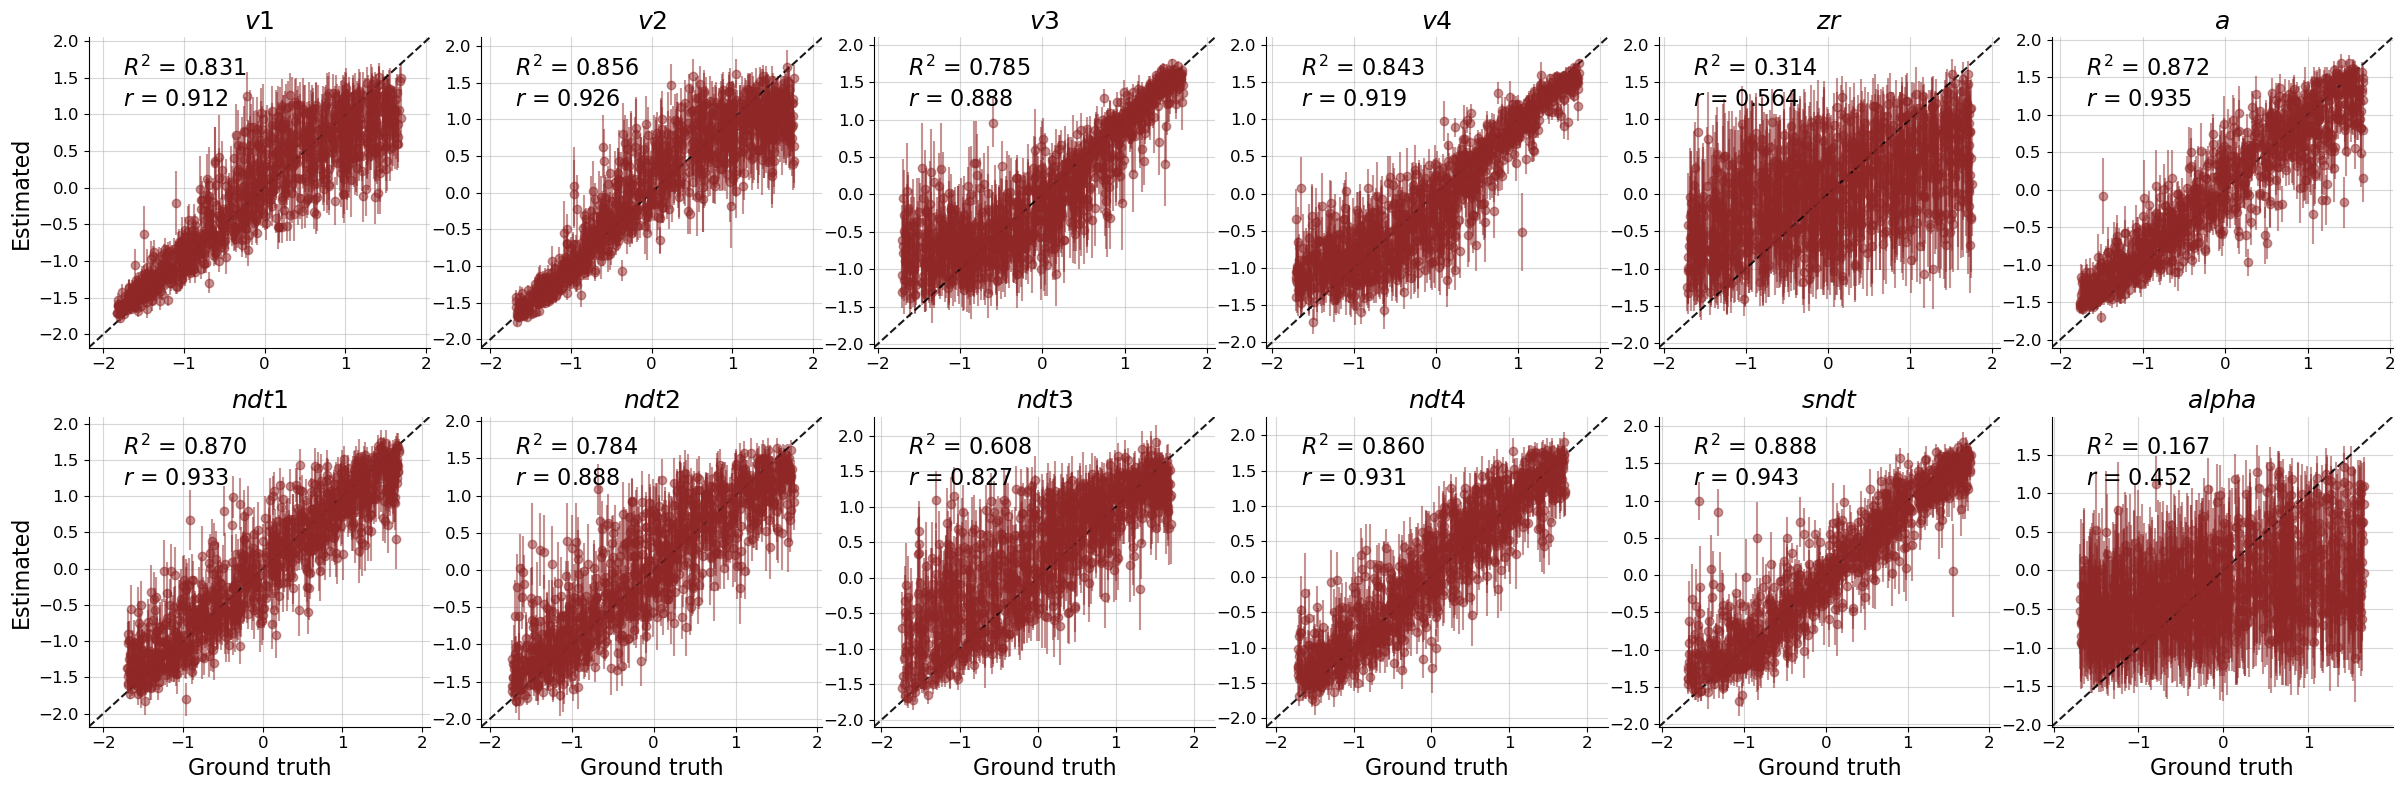

In [31]:
posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
#param_names=[r'$v1_w_a$',r'$v2_w_non$',r'$v3_nW_a$',r'$v4_nW_non$',r'$zr$', r'$a$', r'$ndt1_w_a$',r'$ndt2_w_non$',r'$ndt3_nW_a$',r'$ndt4_nW_non$',r'$sndt$',r'$alpha$']
param_names=[r'$v1$',r'$v2$',r'$v3$',r'$v4$',r'$zr$', r'$a$', r'$ndt1$',r'$ndt2$',r'$ndt3$',r'$ndt4$',r'$sndt$',r'$alpha$']

fig = bf.diagnostics.plot_recovery(posterior_draws, new_sims['parameters'],param_names=param_names)

In [32]:
posterior_draws.shape

(1000, 5000, 12)

IndexError: unsupported iterator index

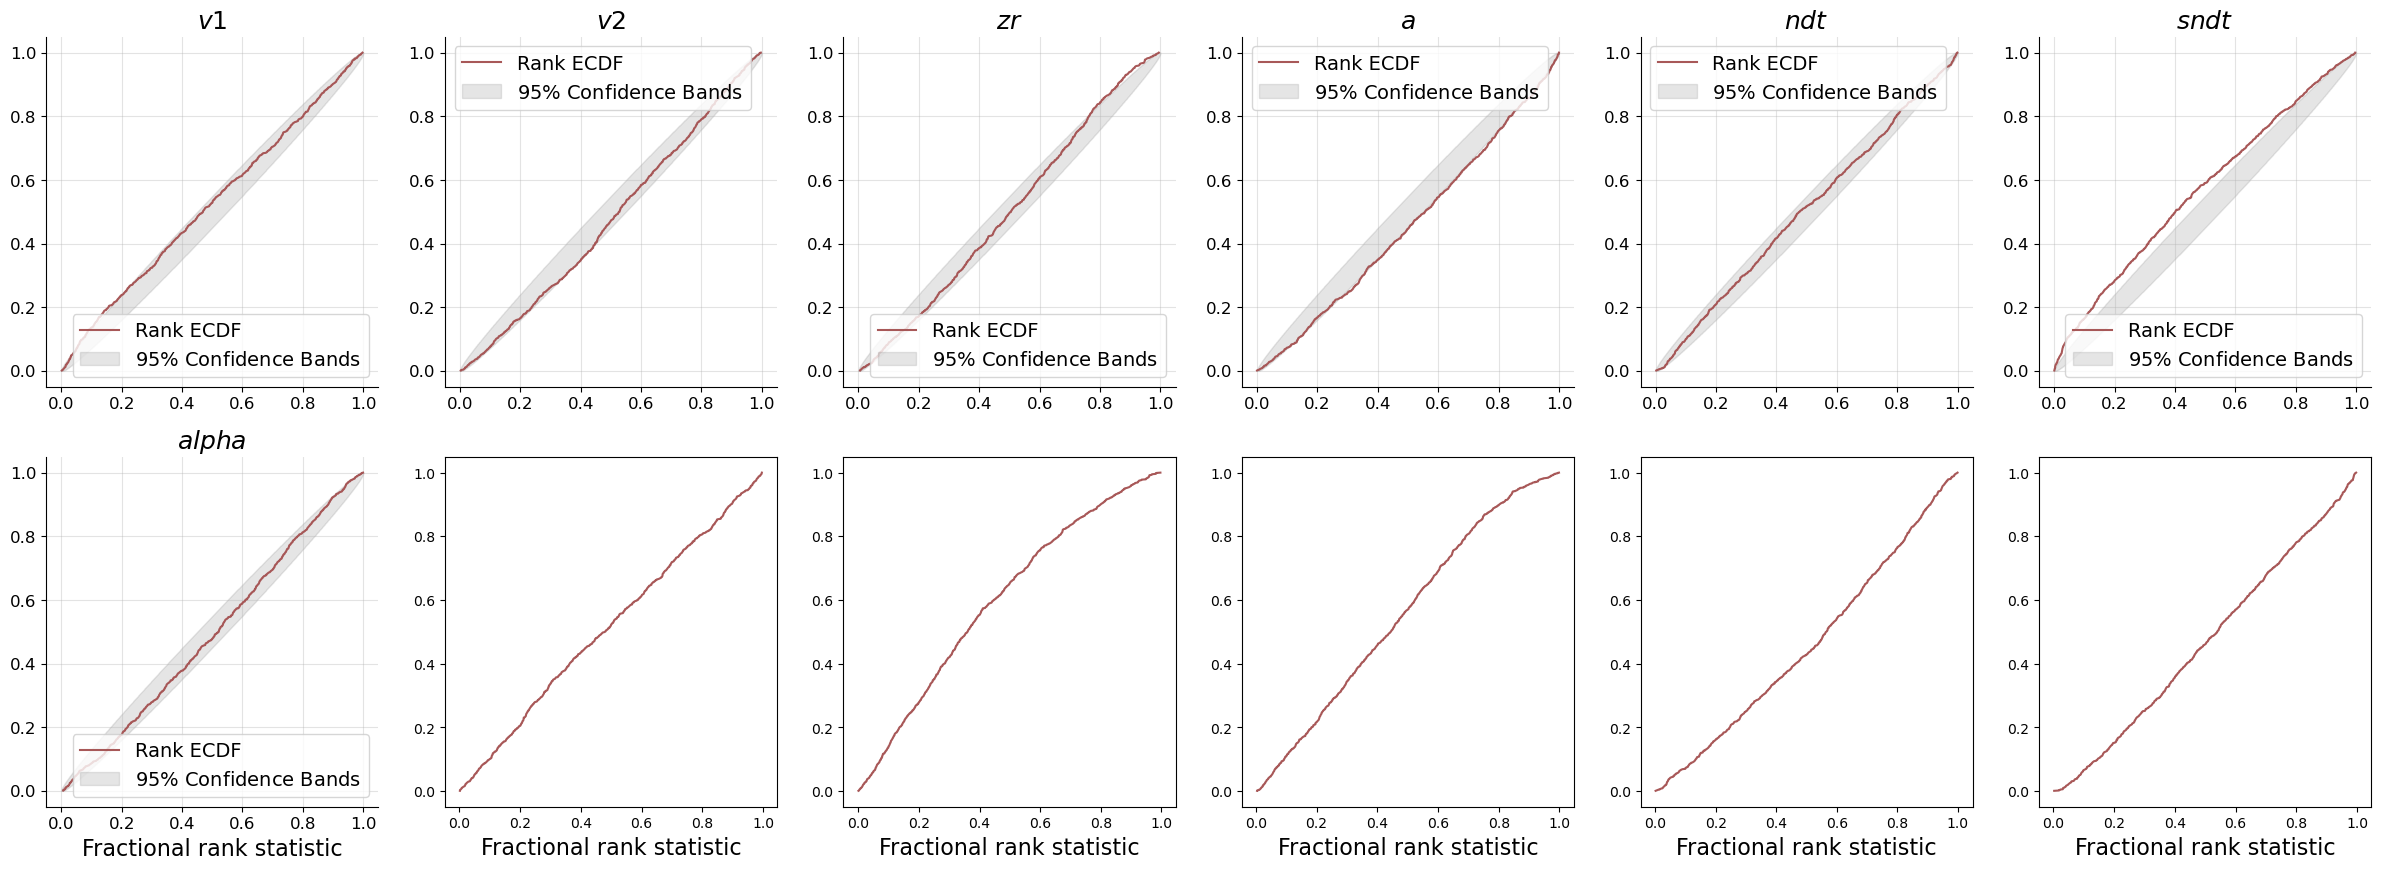

In [33]:
#posterior_draws = amortizer.sample(new_sims, n_samples=100)
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'],param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

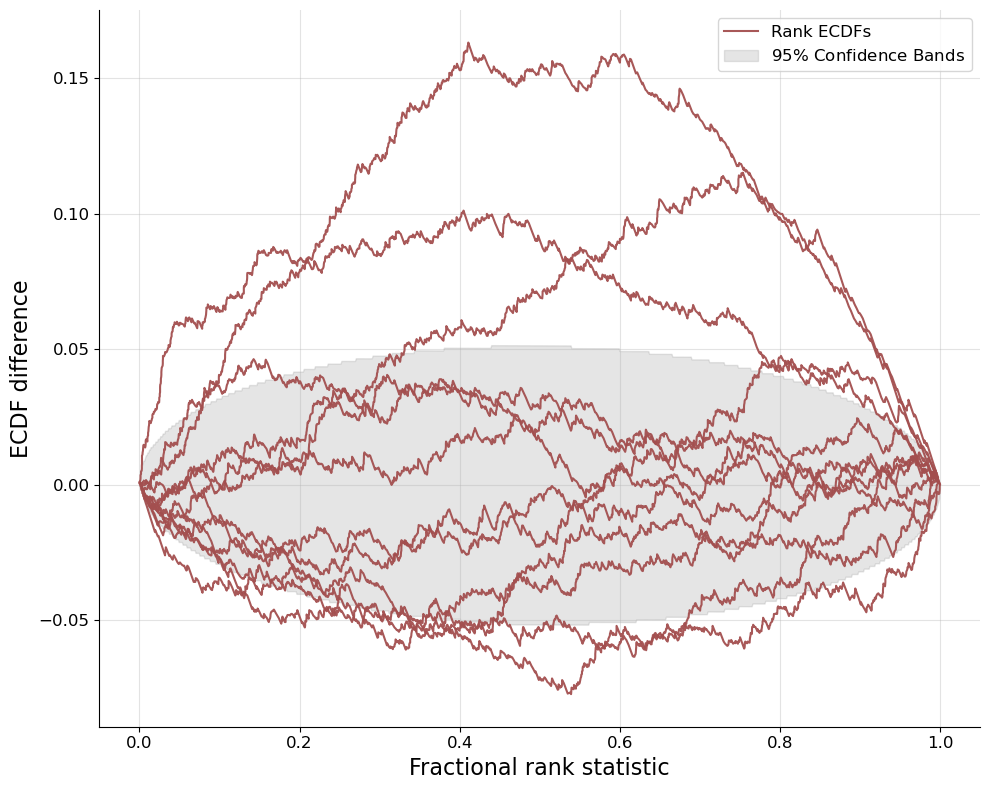

In [35]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'], stacked=True, 
                       difference=True, legend_fontsize=12, fig_size=(10, 8))

In [ ]:
posterior_draws = amortizer.sample(new_sims, n_samples=50)
f = bf.diagnostics.plot_sbc_histograms(posterior_draws, new_sims['parameters'], num_bins=10,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

In [ ]:
#posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
# Michael Nunez's recovery function
def recovery(possamps, truevals):  # Parameter recovery plots
    """Plots true parameters versus 99% and 95% credible intervals of recovered
    parameters. Also plotted are the median (circles) and mean (stars) of the posterior
    distributions.

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is the
    number of chains, the second to last dimension is the number of samples in
    each chain, all other dimensions must match the dimensions of truevals

    truevals : ndarray of true parameter values
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))
    truevals = np.reshape(truevals, (nvars))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    for v in range(0, nvars):
        # Compute percentiles
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Plot credible intervals
            credint = np.ones(100) * truevals[v]
            y = np.linspace(bounds[b], bounds[-1 - b], 100)
            lines = plt.plot(credint, y)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark median
                mmedian = plt.plot(truevals[v], np.median(alldata[v, :]), 'o')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(truevals[v], np.mean(alldata[v, :]), '*')
                plt.setp(mmean, markersize=10, color=teal)
    # Plot line y = x
    tempx = np.linspace(np.min(truevals), np.max(
        truevals), num=100)
    recoverline = plt.plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color=orange)


# Plot the results
fig=plt.figure(figsize=(15,8), tight_layout=True)

columns = 3
rows = 3
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
for i in range(len(param_names)):
    
    fig.add_subplot(rows, columns, i+1)
    recovery(posterior_draws[:, :, i].reshape(num_test, num_posterior_draws_recovery, 1), new_sims['parameters'][:, i].squeeze())
    plt.xlabel('Grand truth', fontsize=16)
    plt.ylabel('Posterior', fontsize=16)
    plt.title(param_names[i], fontsize=16)
    if i==0:
        plt.legend(['99% CI','95% CI','Median', 'Mean'], fontsize=11, loc = 'upper left')




In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import r2_score
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
def compute_performance_metrics(model, n_points_grid, param_names, 
                                 n_sim=20, n_test=300, n_samples=2000, transform=None):
    """
    Compute metrics for different numbers of datapoints.
    ---------

    Arguments:
    model           : tf.keras.Model -- the invertible chaoin with an optional summary net
                                        both models are jointly trained
    param_names     : list of strings -- the names of the parameters
    simulate_fun    : callable -- the simulate function
    n_test          : number of test datasets
    n_samples       : number of samples from the approximate posterior
    transform       : callable ot None -- a function to transform X and theta, if given
    ----------

    Returns:
    metrics : dict -- a dictionary with the metrics
    """

    metrics = {
        'rmse':  {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'nrmse': {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'r2':    {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'std':   {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names}
    }
    
    with tqdm(total=n_points_grid.shape[0]) as p_bar:
        for n, n_points in enumerate(n_points_grid):
            def prior_N(n_min=n_points, n_max=n_points):
                return np.random.randint(n_min, n_max+1)
            p_bar.set_postfix_str("Simulating with N={}".format(n_points))
            for si in range(n_sim):
                
                # Simulate data 
                prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
                var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
                simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
                generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')
                
                x = configurator(generative_model(n_test))
                theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']
                
               # X_test_s, theta_test_s = simulate_fun(n_test, n_points=n_points)
               # if transform is not None:
               #     X_test_s, theta_test_s = transform(X_test_s, theta_test_s)
               # theta_test_s = theta_test_s.numpy()

                # Sample from posterior and compute mean and variance
                posterior_draws = model.sample(x, n_samples=n_samples)
                theta_test_hat = posterior_draws.mean(1)
                theta_test_std = posterior_draws.std(axis=1, ddof=1)

                
                #theta_samples = model.sample(X_test_s, n_samples=n_samples, to_numpy=True)
                #theta_test_hat = theta_samples.mean(0)
                #theta_test_std = theta_samples.std(axis=0, ddof=1)

                # --- Plot true vs estimated posterior means on a single row --- #
                for k, name in enumerate(param_names):

                    # Compute NRMSE
                    rmse = np.sqrt(np.mean( (theta_test_hat[:, k] - theta_test_s[:, k])**2 ))
                    nrmse = rmse / (theta_test_s[:, k].max() - theta_test_s[:, k].min())

                    # Compute R2
                    r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

                    # Extract mean posterior std
                    std = np.mean(theta_test_std[:, k])

                    # Add to dict
                    metrics['rmse'][name][n, si] = rmse
                    metrics['nrmse'][name][n, si] = nrmse
                    metrics['r2'][name][n, si] = r2
                    metrics['std'][name][n, si]  = std
            p_bar.update(1)
        return metrics


In [ ]:
n_points_grid=np.arange(100, 1001, 10)

metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    #simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000)
                    #transform=transform)

In [ ]:
def plot_performance_metrics(metrics, n_points_grid, param_names, figsize=(12, 4), show=True, 
                             xlabel=r'$n$', filename=None, legend_loc=None, std_ci=2, font_size=12):
    
    """Plots specified metrics over ns."""

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Initialize figure
    f, axarr = plt.subplots(1, 2, figsize=figsize)

    for i, metric in enumerate(['nrmse', 'r2']):
        for p in param_names:

            metric_mean = metrics[metric][p].mean(axis=1)
            metric_std = metrics[metric][p].std(axis=1, ddof=1)

            axarr[i].plot(n_points_grid, metric_mean, label=p, lw=2)
            axarr[i].fill_between(n_points_grid, 
                            metric_mean-std_ci*metric_std, 
                            metric_mean+std_ci*metric_std, 
                            interpolate=True, alpha=0.2)

        if metric == 'nrmse':
            axarr[i].set_ylabel('NRMSE')
        elif metric == 'r2':
            axarr[i].set_ylabel(r'$R^{2}$')
        axarr[i].set_xlabel(xlabel)

        axarr[i].spines['right'].set_visible(False)
        axarr[i].spines['top'].set_visible(False)
        if legend_loc is not None:
            axarr[i].legend(loc=legend_loc[i], fontsize=10)
        else:
            axarr[i].legend(fontsize=12)

    f.tight_layout()
    
    if show:
        plt.show()
    
    if filename is not None:
        f.savefig("figures/{}_metrics.png".format(filename), dpi=600, bbox_inches='tight')



In [ ]:
plot_performance_metrics(metrics, 
                         n_points_grid, 
                         param_names, 
                         legend_loc=['upper right', 'lower right'],
                         xlabel=r'Number of trials ($N$)', 
                         figsize=(12, 6),
                         filename='Levy_Metrics')

In [ ]:
x = configurator(generative_model(32))
theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']

In [ ]:
X_test_s.shape

In [ ]:
n_samples  = 1000
posterior_draws = amortizer.sample(x, n_samples=num_posterior_draws_recovery)
#theta_samples = amortizer.sample(X_test_s, n_samples=n_samples)

In [ ]:
posterior_draws.shape

In [ ]:
theta_test_hat = posterior_draws.mean(1)
theta_test_std = posterior_draws.std(axis=1, ddof=1)


In [ ]:
theta_test_hat.shape

In [ ]:
theta_test_hat

In [ ]:
theta_test_std.shape

In [ ]:
theta_test_std

In [ ]:
r2 = r2_score(theta_test_s[:,1], theta_test_hat[:,1])

In [ ]:
r2 = r2_score(theta_test_s[:,2], theta_test_hat[:,2])
r2

In [ ]:
r2

In [ ]:
r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

In [ ]:
theta_test_s.shape

In [ ]:
n_points_grid=np.arange(100, 121, 10)
for n, n_points in enumerate(n_points_grid):
    print (n_points)

In [ ]:
n_points_grid=np.arange(100, 121, 10)
metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000
                    )

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp,param_names=prior.param_names)

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp, prior=prior)

In [ ]:
import matplotlib.pyplot as plt

def plot_ppc(config, post_samples, logscale=True, color='Blue', 
                            dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_cases = stationary_SIR(samples[i], config['N'], config['T'])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)
    
    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label='Median predicted cases', color=color)
    ax.plot(config['obs_data'], marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
    
    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config['T']), qs_50[0], qs_50[1], color=color, alpha=0.3, label='50% CI')
    ax.fill_between(range(config['T']), qs_90[0], qs_90[1], color=color, alpha=0.2, label='90% CI')
    ax.fill_between(range(config['T']), qs_95[0], qs_95[1], color=color, alpha=0.1, label='95% CI')
    
    # Grid and schmuck
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days since pandemic onset')
    ax.set_ylabel('Number of cases')
    ax.minorticks_off()
    if logscale:
        ax.set_yscale('log')
    ax.legend(fontsize=font_size)
    return f

In [ ]:
f = plot_ppc(config, post_samples)
